In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn.linear_model
%matplotlib inline

Utilizando los datos de Default construya una curva de precision-recall con los resultados del modelo regresión logística 
(http://scikit-learn.org/stable/auto_examples/model_selection/plot_precision_recall.html). 
Escriba su propia función. No utilice la de sklearn.

(0, 1)

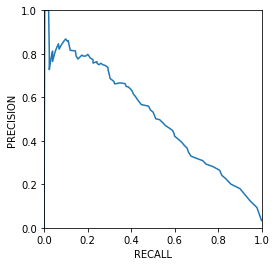

In [4]:
#Load data and define X, Y
data = pd.read_csv('Default.csv')
Y = data['default']
X = data['balance'].values.reshape(-1,1)

# Initialize fitting method, fit and predict
f = sklearn.linear_model.LogisticRegression()
f.fit(X, Y)
predict = f.predict(X)

# This is the probability for Default='Yes'
proba_yes = f.predict_proba(X)[:,1]

# loop over n_p different values for the threshold probabiity
n_p = 100
error_rate = np.zeros(n_p)
precision = np.zeros(n_p)
recall = np.zeros(n_p)
threshold = np.linspace(0,0.99, n_p)
for i in range(n_p):
    ii = proba_yes>threshold[i]
    predict[ii] = 'Yes'
    predict[~ii] = 'No'
    true_positive = (Y == 'Yes') & (predict == 'Yes') 
    false_positive = (Y == 'No') & (predict == 'Yes')
    false_negative = (Y == 'Yes') & (predict == 'No')  
    n_tp = np.count_nonzero(true_positive)
    n_fp= np.count_nonzero(false_positive)
    n_fn = np.count_nonzero(false_negative)
    if((n_tp+n_fp)>0): precision[i] = n_tp/(n_tp + n_fp)
    if((n_tp+n_fn)>0): recall[i] = n_tp/(n_tp + n_fn)    

plt.axes().set_aspect('equal')        
plt.plot(recall, precision)
plt.xlabel('RECALL')
plt.ylabel('PRECISION')
plt.xlim([0,1])
plt.ylim([0,1])


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [34]:
np.count_nonzero(Y == 'Yes')

333

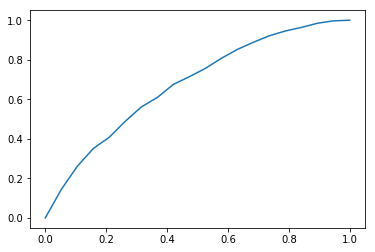

In [54]:
plt.plot(limite_proba, error_rate)

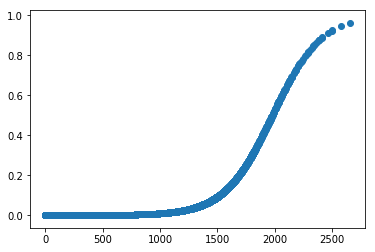

In [19]:
#plt.scatter(X, Y)
plt.scatter(X, f.predict_proba(X)[:,1])

In [93]:
def sigma(x):
    return np.exp(x) / (1.0 + np.exp(x))

model = sigma(X * f.coef_ + f.intercept_)

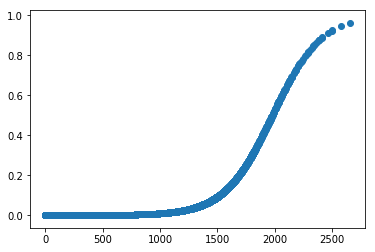

In [94]:
plt.scatter(X, model)

In [69]:
Y = data['default']
X = data[['balance','income']]
f.fit(X, Y)
print(f.coef_,f.intercept_)

[[ 0.00040756 -0.00012588]] [ -1.94164125e-06]


In [70]:
data = pd.read_csv('Smarket.csv')

In [71]:
data[0:1]

,Unnamed: 0,Year,Lag1,Lag2,Lag3,Lag4,Lag5,Volume,Today,Direction
0,1,2001,0.381,-0.192,-2.624,-1.055,5.01,1.1913,0.959,Up


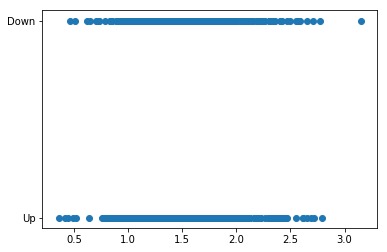

In [76]:
plt.scatter(data['Volume'], data['Direction'])